used tutorial: https://muthu.co/segmenting-lines-in-handwritten-documents-using-a-path-planning-algorithm/

# TO DO:


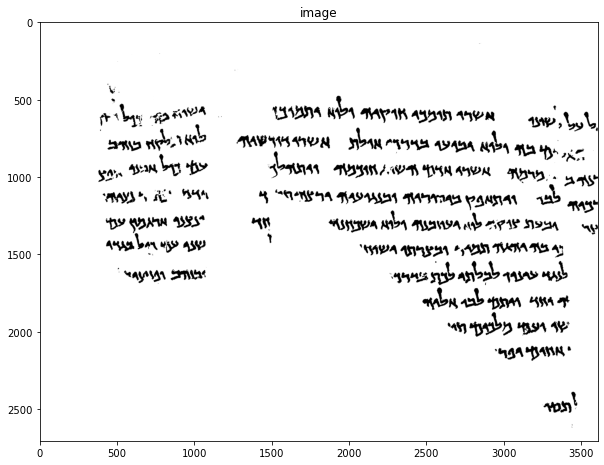

In [1]:
from skimage.io import imread
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
import cv2
import numpy as np


easy_scroll = r'/Users/joostfranssen/Documents/Study/MSc_AI/Year_1/Semester_2B/HWR/image-data/P168-Fg016-R-C01-R01-binarized.jpg'
hard_scroll = r'/Users/joostfranssen/Documents/Study/MSc_AI/Year_1/Semester_2B/HWR/image-data/P22-Fg008-R-C01-R01-binarized.jpg' 
huge_scroll = r'/Users/joostfranssen/Documents/Study/MSc_AI/Year_1/Semester_2B/HWR/image-data/P344-Fg001-R-C01-R01-binarized.jpg'
half_sentences_scroll = r'/Users/joostfranssen/Documents/Study/MSc_AI/Year_1/Semester_2B/HWR/image-data/P106-Fg002-R-C01-R01-binarized.jpg'
divided_scroll = r'/Users/joostfranssen/Documents/Study/MSc_AI/Year_1/Semester_2B/HWR/image-data/P423-1-Fg002-R-C01-R01-binarized.jpg' 
curly_scroll = r'/Users/joostfranssen/Documents/Study/MSc_AI/Year_1/Semester_2B/HWR/image-data/P123-Fg002-R-C01-R01-binarized.jpg' 
vague_scroll = r'/Users/joostfranssen/Documents/Study/MSc_AI/Year_1/Semester_2B/HWR/image-data/P166-Fg007-R-C01-R01-binarized.jpg'


image = cv2.imread(divided_scroll, cv2.IMREAD_UNCHANGED)

plt.figure(figsize=(10,10))
plt.axis()
plt.title("image")
plt.imshow(image, cmap="gray")
plt.show()

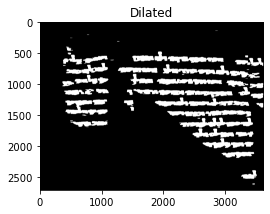

In [71]:
#maybe use this instead of the other gray image becaus here the small things are removed and we can find a better path i think.

def thresholding(image):
    _ ,thresh = cv2.threshold(image,80,255,cv2.THRESH_BINARY_INV)
#     plt.figure(figsize=(4,4))
#     plt.title("Thresholded")
#     plt.imshow(thresh, cmap='gray')
    return thresh

thresh_img = thresholding(image)

#dilation
#We can change the dilation to create larger letters if we want to.first num is vertical, second num is horizontal dilation
#3,15 is the one used since the beginning, we can change to other settings if we like
kernel = np.ones((4,35), np.uint8)
dilated = cv2.dilate(thresh_img, kernel, iterations = 1)

plt.figure(figsize=(4,4))
plt.title("Dilated")
plt.imshow(dilated, cmap='gray')
plt.show()

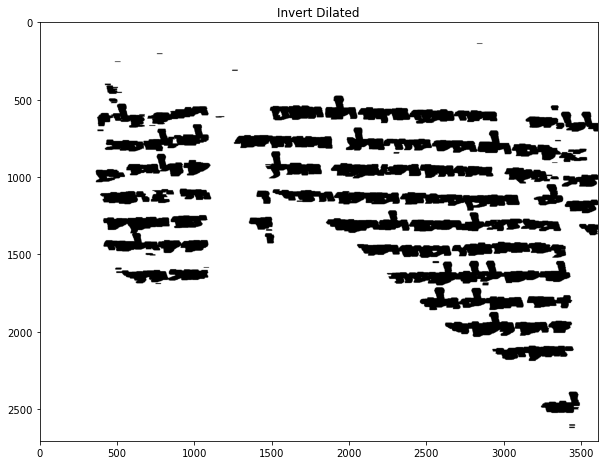

In [3]:
#Invert the image back from black background to white background, for the path finder. 
invert = cv2.bitwise_not(dilated)

plt.figure(figsize=(10,10))
plt.imshow(invert, cmap='gray')
plt.title("Invert Dilated")
plt.show()

img = invert

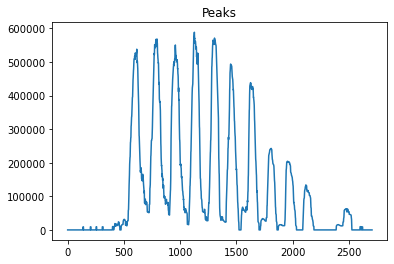

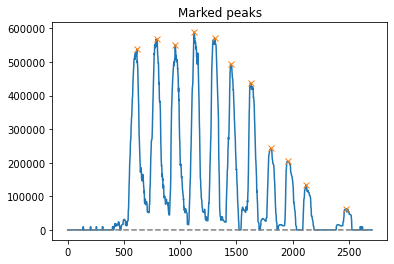

In [4]:
import matplotlib.pyplot as plt
from scipy.signal import find_peaks


def horizontal_projections(image):
    return np.sum(image, axis=1) 

hpp = horizontal_projections(dilated)
plt.plot(hpp)
plt.title("Peaks")
plt.show()


# The minimum_peak is just a treshold value for what number a peak minimum has to consist of. 
# The distance in the find_peaks() function seperates the peaks by a distance of minimum of 100. With the highest peak being selected. 
minimum_peak = int((np.max(hpp)-np.min(hpp))/12)
peaks, _ = find_peaks(hpp, height=minimum_peak, distance=100)
plt.plot(hpp)
plt.title("Marked peaks")
plt.plot(peaks, hpp[peaks], "x")
plt.plot(np.zeros_like(hpp), "--", color="gray")
plt.show()

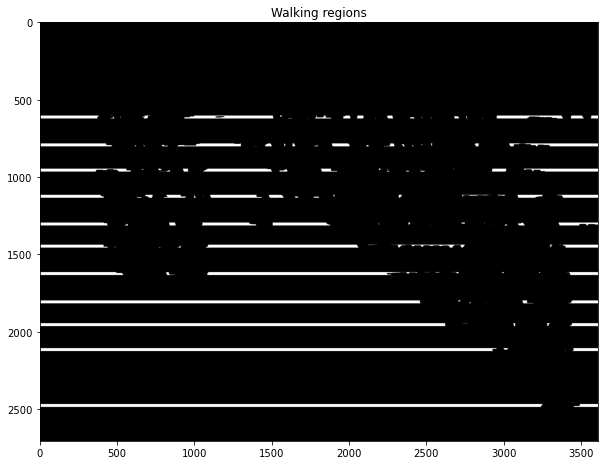

In [5]:
#Use the calculated peaks to create small areas of where there must be sentences. 
def find_not_peak_regions(hpp):
    not_peaks = []
    not_peaks_index = []
    count = 0
    x = 0
    line_size = 10
    for i, hppv in enumerate(hpp):
        if x > (len(peaks) - 1):
            not_peaks.append([i, hppv])
        elif i < (peaks[x] - line_size) or i > (peaks[x] + line_size):
            not_peaks.append([i, hppv])
        else:
            count += 1
            if count == ((line_size*2) - 1):
                x += 1
                count = 0
    return not_peaks

not_peaks = find_not_peak_regions(hpp)

not_peaks_index = np.array(not_peaks)[:,0].astype(int)


#Displays the image below
segmented_img = np.copy(img)
r,c = segmented_img.shape
for ri in range(r):
    if ri in not_peaks_index:
        segmented_img[ri, :] = 0
        
plt.figure(figsize=(10,10))
plt.title("Walking regions")
plt.imshow(segmented_img, cmap="gray")
plt.show()

In [6]:
#The Hpp_clusters is the black areas such that we have walking regions for the algorithm

#Create walking regions in the image
def get_hpp_walking_regions(peaks_index):
    hpp_clusters = []
    cluster = []
    for index, value in enumerate(peaks_index):
        cluster.append(value)

        if index < len(peaks_index)-1 and peaks_index[index+1] - value > 1:
            hpp_clusters.append(cluster)
            cluster = []

        #get the last cluster
        if index == len(peaks_index)-1:
            hpp_clusters.append(cluster)
            cluster = []
            
    return hpp_clusters

hpp_clusters = get_hpp_walking_regions(not_peaks_index)

In [7]:
#Copied from the github mentioned above, adjusted for our problem. Created a range of goals.

#a star path planning algorithm 
from heapq import *

def heuristic(a, b):
    return (b[0] - a[0]) ** 2 + (b[1] - a[1]) ** 2

def astar(array, start, goal):
    
    #print("start: " + str(start))
    #print("end: " + str(goal))
    neighbors = [(0,1),(0,-1),(1,0),(-1,0),(1,1),(1,-1),(-1,1),(-1,-1)]
    close_set = set()
    came_from = {}
    gscore = {start:0}
    fscore = {start:heuristic(start, goal)}
    oheap = []

    heappush(oheap, (fscore[start], start))
    
    lower_limit = goal[0]
    upper_limit = goal[0] + lower_limit 
    
    count = 0
    while oheap:
        count += 1
        
        current = heappop(oheap)[1]
        
        #If there is not a path break after 100 times the length of the input iterations
        if count > goal[1]*30:
            break
            
        #The goal of the path finder can be somewhere in the range of the walking region at the end
        if current[1] == goal[1] and (current[0] > lower_limit and current[0] < upper_limit):
            data = []
            while current in came_from:
                data.append(current)
                current = came_from[current]
            return data

        close_set.add(current)
        for i, j in neighbors:
            neighbor = current[0] + i, current[1] + j            
            tentative_g_score = gscore[current] + heuristic(current, neighbor)
            if 0 <= neighbor[0] < array.shape[0]:
                if 0 <= neighbor[1] < array.shape[1]:                
                    if array[neighbor[0]][neighbor[1]] == 1:
                        continue
                else:
                    # array bound y walls
                    continue
            else:
                # array bound x walls
                continue
                
            if neighbor in close_set and tentative_g_score >= gscore.get(neighbor, 0):
                continue
                
            if  tentative_g_score < gscore.get(neighbor, 0) or neighbor not in [i[1]for i in oheap]:
                came_from[neighbor] = current
                gscore[neighbor] = tentative_g_score
                fscore[neighbor] = tentative_g_score + heuristic(neighbor, goal)
                heappush(oheap, (fscore[neighbor], neighbor))      
    return []

In [8]:
# #Copied from the github mentioned above
from skimage.filters import threshold_otsu

def get_binary(img):
    mean = np.mean(img)
    if mean == 0.0 or mean == 1.0:
        return img

    thresh = threshold_otsu(img)
    binary = img <= thresh
    binary = binary*1
    return binary

In [9]:
#Segment all the lines using the A* algorithm
binary_image = get_binary(img)

line_segments = []
for i, cluster_of_interest in enumerate(hpp_clusters):
    nmap = binary_image[cluster_of_interest[0]:cluster_of_interest[len(cluster_of_interest)-1],:]
    
    #The goal given is the middle of the walking region. But we adjusted in the path finder to the complete range.
    path = np.array(astar(nmap, (int(nmap.shape[0]/2), 0), (int(nmap.shape[0]/2), nmap.shape[1]-1)))
   
    #Finding a path is impossible, then just draw a straight line from begin to end
    if path.shape[0] == 0:
        line_new = []
        size_cluster = int(nmap.shape[0]/2)
        for i in range(nmap.shape[1] - 1):
            line_new.append([size_cluster, nmap.shape[1]-i -1])
            line = []
        line_new = np.asarray(line_new)
        offset_from_top = cluster_of_interest[0]
        line_new[:,0] += offset_from_top
        line_segments.append(line_new)
    else:
        offset_from_top = cluster_of_interest[0]
        path[:,0] += offset_from_top
        line_segments.append(path)

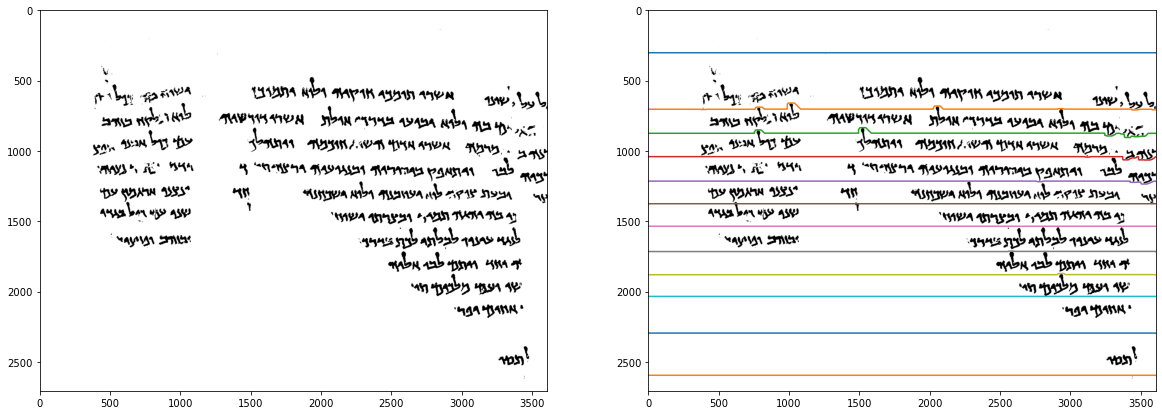

In [10]:
#Print the created path throught the first inputted image
offset_from_top = cluster_of_interest[0]
fig, ax = plt.subplots(figsize=(20,20), ncols=2)
for path in line_segments:
    ax[1].plot((path[:,1]), path[:,0])
ax[1].axis()
ax[0].axis()
ax[1].imshow(image, cmap="gray")
ax[0].imshow(image, cmap="gray")

In [11]:
from PIL import Image

def white_array(height, width):
    image = np.zeros([height,width],dtype=np.uint8)
    image.fill(255)
    return image

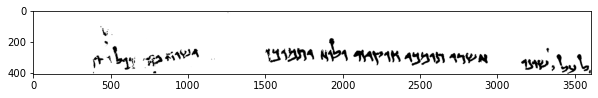

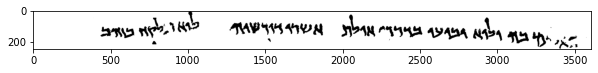

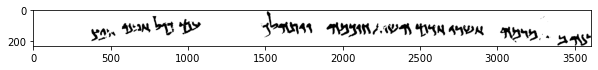

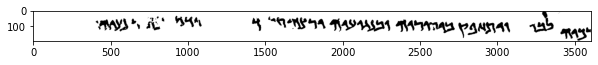

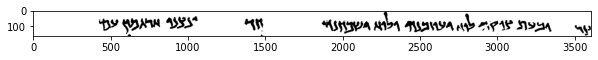

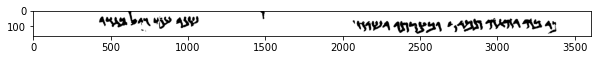

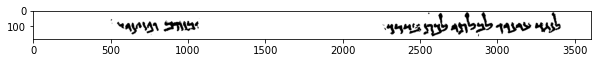

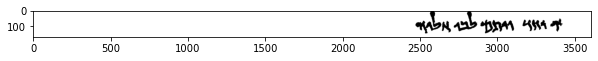

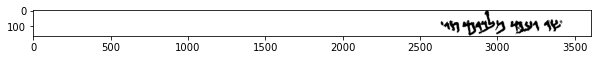

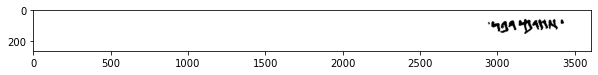

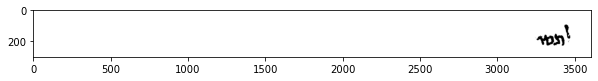

In [12]:
#Loop to create the seperate line images
line_count = len(line_segments)
line_image = []

for line_index in range(line_count-1):
    upper_bound = np.min(line_segments[line_index][:, 0])
    lower_bound = np.max(line_segments[line_index+1][:, 0])
    height = lower_bound - upper_bound
    width = image.shape[1]
    white_line_image = white_array(height, width)
    offset_top = upper_bound
    
    
    #Creates white areas around the sentences, such that bits and pieces of other sentences do not get in the line image
    for i in range(white_line_image.shape[0]):
        for j in range(white_line_image.shape[1] -1):
            if (line_segments[line_index][white_line_image.shape[1] - 2 - j][0] - i > upper_bound) or (i + offset_top > line_segments[line_index+1][white_line_image.shape[1] - 2 - j][0]) :              
                white_line_image[i][j] = 255     
            else:
                white_line_image[i][j] = image[upper_bound + i][j]

    line_image.append(white_line_image)
    
    plt.figure(figsize=(10,10))
    plt.imshow(white_line_image, cmap="gray")
    plt.show()

## Word segmentation

First we need to downsize the white part in the first and last lines.

# First option for word segmentation

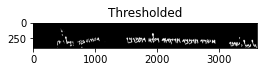

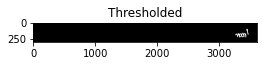

In [13]:
def remove_top_image(image):
    thresh_image = thresholding(image)
    hpp_image = horizontal_projections(thresh_image)
    for i in range(len(hpp_image)):
        if hpp_image[i] != 0:
            image_new = image[i:, :]
            break 
    return image_new

def remove_bottom_image(image):
    thresh_image = thresholding(image)
    hpp_image = horizontal_projections(thresh_image)
    for i in range(len(hpp_image)-1, 0, -1):
        if hpp_image[i] != 0:
            image_new = image[:i, :]
            break 
    return image_new



first_line = line_image[0]
last_line = line_image[len(line_image)-1]

line_image[0] = remove_top_image(first_line)
line_image[len(line_image)-1] = remove_bottom_image(last_line)    

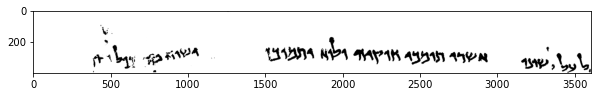

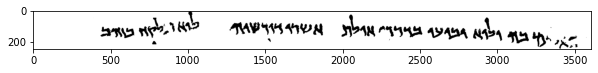

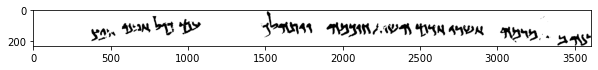

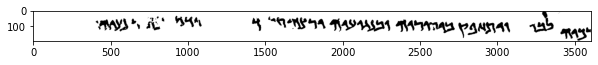

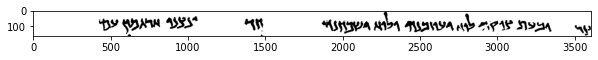

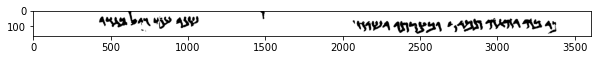

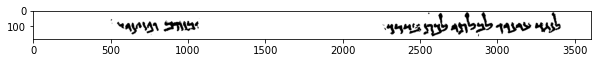

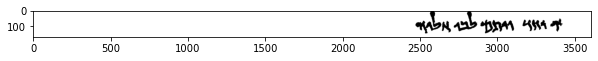

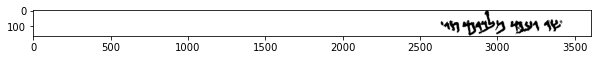

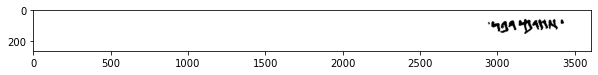

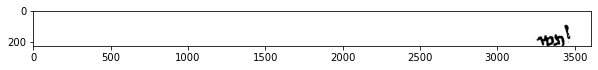

In [14]:
for i in range(len(line_image)):
    plt.figure(figsize=(10,10))
    plt.imshow(line_image[i], cmap="gray")
    plt.show()

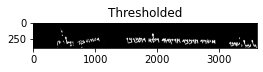

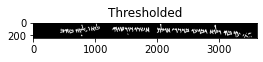

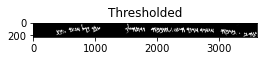

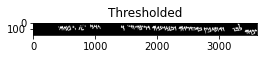

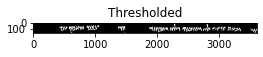

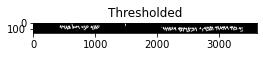

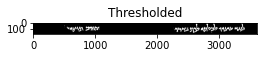

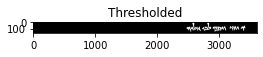

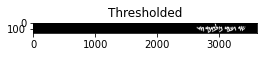

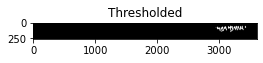

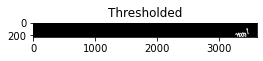

In [15]:
def vertical_projections(image):
    return np.sum(image, axis=0) 

def remove_noise(image):
    return cv2.medianBlur(image, 5)

#preprocesses the lines
def pre_process_lines(lines):
    pre_processed_lines = []
    kernel = np.ones((10,10), np.uint8)
    
    for i in range(len(lines)):
        line = lines[i]
        
        #threshold line
        thresh_line = thresholding(line)
        
        #remove noise
        noise_free_line = remove_noise(thresh_line)
        
        #dilate the remaining part
        dilated_line = cv2.dilate(noise_free_line, kernel, iterations = 1)
        
        #append the line
        pre_processed_lines.append(dilated_line)
    return pre_processed_lines


pre_processed_lines = pre_process_lines(line_image)

In [63]:
# #remove small pixels of black and only hold if area is larger than something
# def find_words(vpp_image, image):
#     count = 0
#     lowest = 0
#     highest = 0
#     words = []
#     for i in range(len(vpp_image)):
#         if vpp_image[i] != 0:
#             count+= 1
#         else:
#             if count > 20:
#                 highest = vpp_image[i-1]
#                 word_new = image[:,lowest:i]
#                 words.append(word_new)
#                 count = 0
#             lowest = i
#     return words

# words_per_line = []
# for i in range(len(line_image)):
#     vpp_image = vertical_projections(pre_processed_lines[i])
#     words = find_words(vpp_image, line_image[i])
#     words_per_line.append(words)
    

# for i in range(len(words_per_line[0])):
#     plt.figure(figsize=(5,5))
#     plt.imshow(words_per_line[1][i], cmap="gray")
#     plt.show()

# Based on white areas pixels that are shorter than a certain amount

In [68]:
def find_words_for_zero_period(image, threshold):
    words = []
    vpp_image = vertical_projections(image)
    
    #find indexes where the vpp is not zero, so there are black pixels
    result_zeros = np.where(vpp_image!=0)
    lowest = result_zeros[0][0]
    for i in range(len(result_zeros[0])-1):
        diff = result_zeros[0][i+1] - result_zeros[0][i] 
        
        #skip white periods that are not long enough
        if diff > 1 and diff < threshold:
            continue
        elif diff > 1:
            highest = result_zeros[0][i]
            new_word = [lowest, highest]
            words.append(new_word)
            lowest = result_zeros[0][i+1]
    return words 

def get_word_image(image, index_words):
    words = []
    for i in range(len(index_words)):
        #Get word
        word_new = image[:,index_words[i][0]:index_words[i][1]]
        
        #remove the white area at the top and bottom
        word_bot = remove_bottom_image(word_new)
        word_top = remove_top_image(word_bot)
        
        words.append(word_top)
    return words

In [72]:
words_per_line = []
for line in range(len(line_image)):
    index_words = find_words_for_zero_period(pre_processed_lines[line], 10)
    words = get_word_image(line_image[line], index_words) 
    words_per_line.append(words)

Line 0


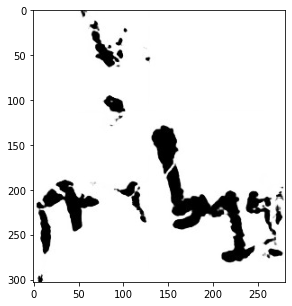

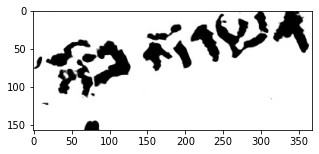

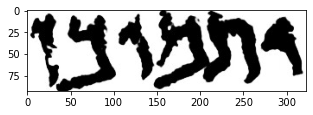

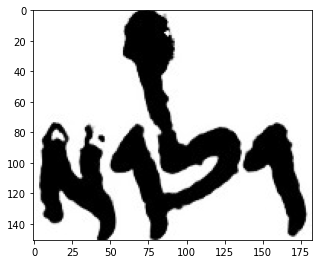

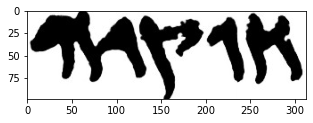

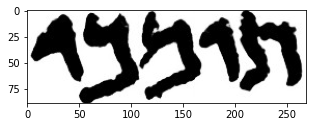

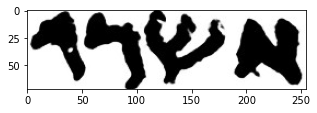

Line 1


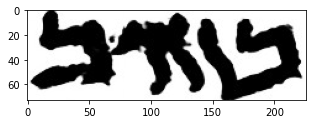

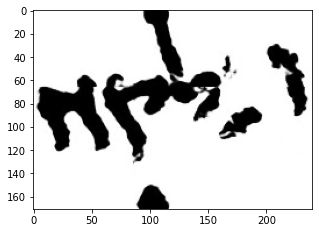

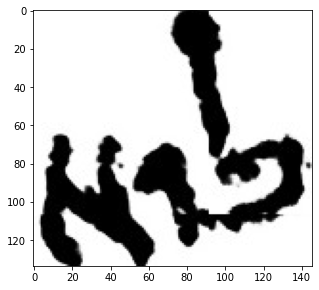

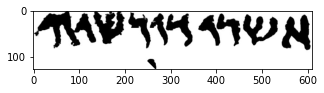

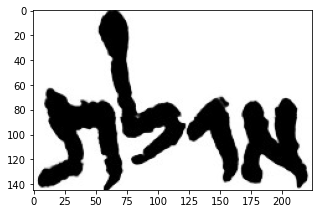

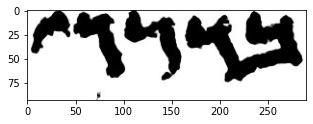

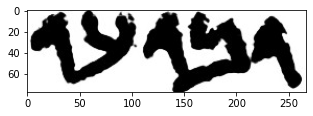

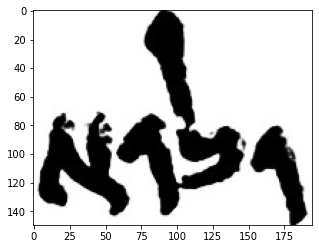

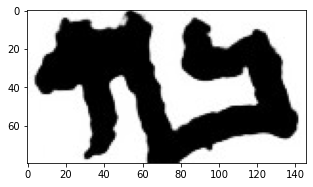

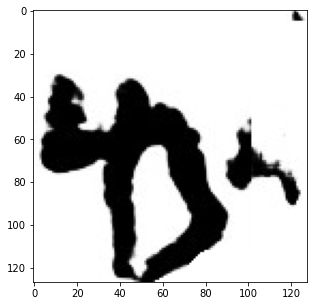

Line 2


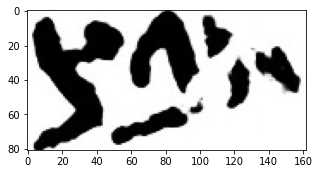

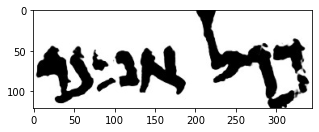

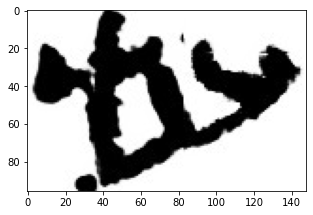

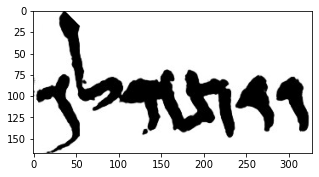

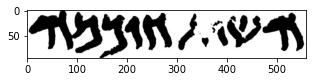

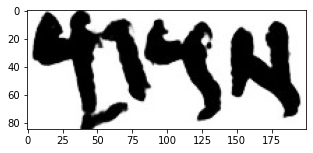

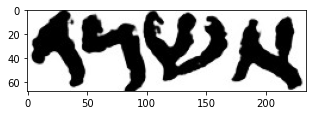

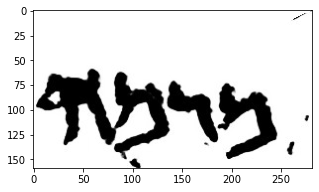

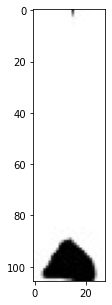

Line 3


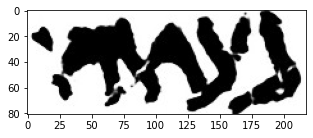

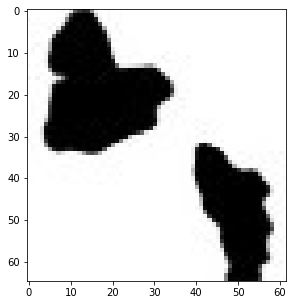

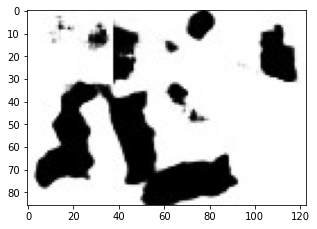

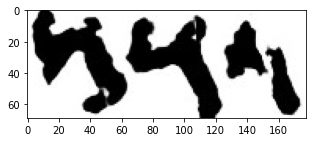

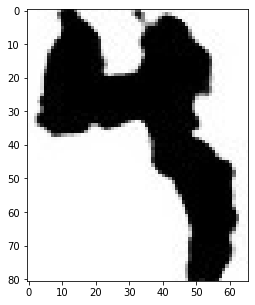

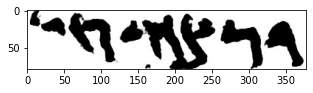

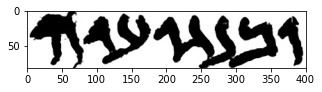

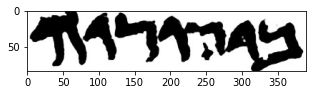

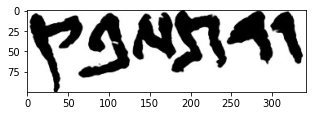

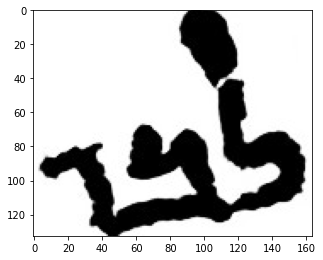

Line 4


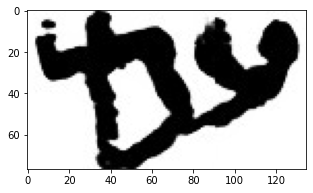

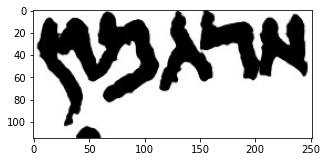

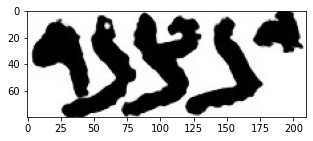

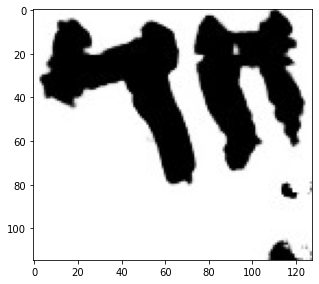

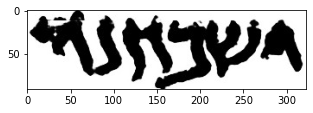

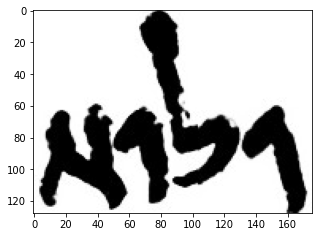

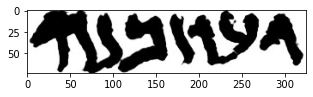

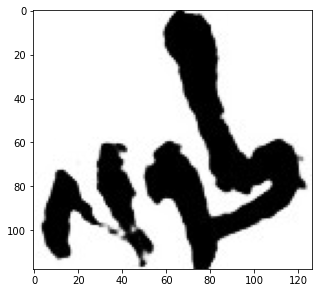

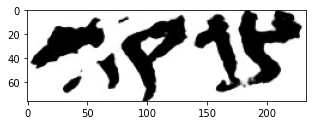

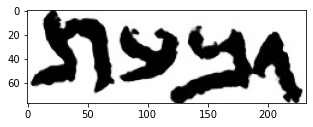

Line 5


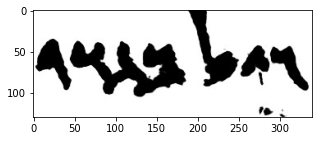

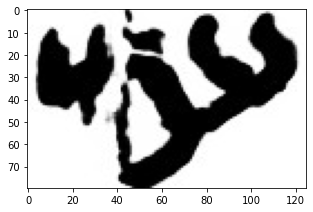

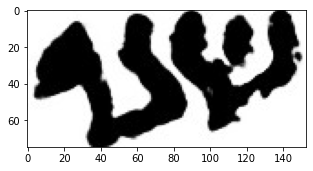

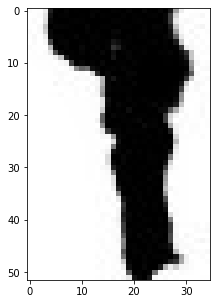

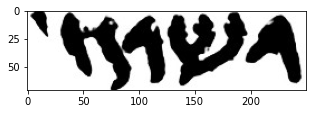

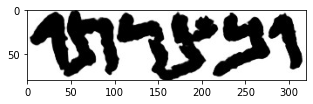

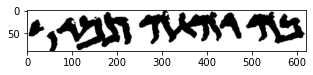

Line 6


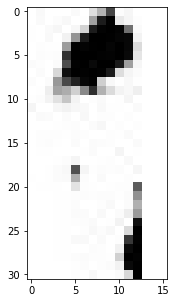

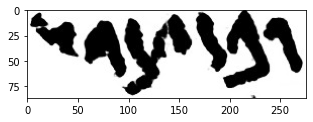

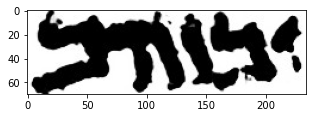

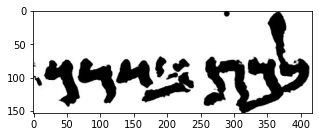

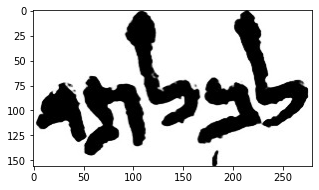

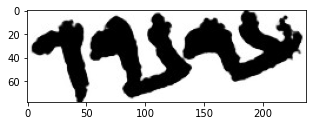

Line 7


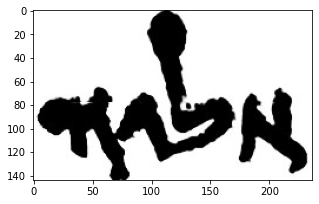

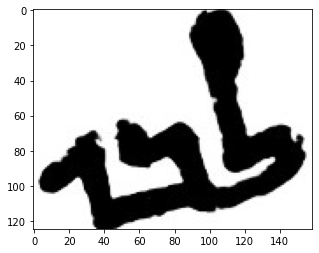

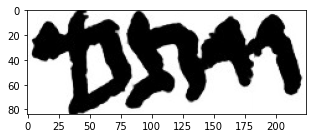

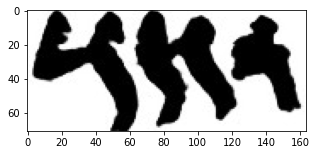

Line 8


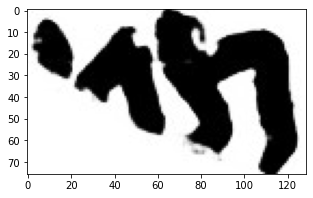

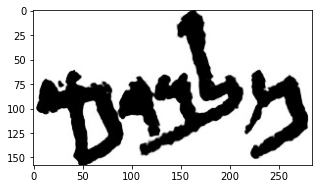

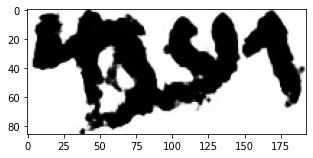

Line 9


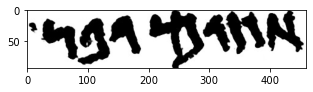

Line 10


In [74]:
for row in range(len(words_per_line)):
    print("Line " + str(row))
    for word in range(len(words_per_line[row])):
        plt.figure(figsize=(5,5))
        plt.imshow(words_per_line[row][word], cmap="gray")
        plt.show()

# Second option for word segmentation, using boudingboxes. Think option above is better

In [ ]:
# def boundingboxes(image, image_dilated,MINSIZE, MAXSIZE):
#     boxcoordinates = []
#     words_image = []
#     letters = []

#     copy = image.copy()
#     thresholded = thresholding(image_dilated)

#     cnts = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#     cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    
#     for c in cnts:
#         topleftx, toplefty, width, height = cv2.boundingRect(c)
#         next_letter = [topleftx, toplefty, width, height]
#         letters.append(next_letter)

#     #Sort letters/words from right to left, because hebrew is written from right to left.
#     letters = sorted(letters, reverse=True)


#     for letter in letters:
#         topleftx, toplefty, width, height = letter

#         #Reject contours that are too big or small to be likely letters
#         if height<MINSIZE or width<MINSIZE:
#             continue

#         if height>MAXSIZE or width>MAXSIZE:
#             continue

#         cv2.rectangle(copy, (topleftx, toplefty), (topleftx + width, toplefty + height), (0,0,255), 2)  
#         boxcoordinates.append((topleftx, toplefty, width, height))

#         character = image[toplefty:toplefty+height, topleftx:topleftx+width]
#         print("shape: "+str(character.shape))
#         plt.figure(figsize=(5,5))
#         plt.imshow(character, cmap="gray")
#         plt.show()
#         words_image.append(character)
    
#     return words_image, copy

In [ ]:
# characters = []
# for lines in range(len(line_image)):
#     print("Line number: " + str(lines))
#     kernel = np.ones((25,30), np.uint8)
    
#     line_image_dilate = cv2.erode(line_image[lines], kernel, iterations=1)
#     plt.figure(figsize=(15,15))
#     plt.imshow(line_image_dilate, cmap="gray")
#     plt.show()
    
#     words, image_inc_b = boundingboxes(line_image[lines], line_image_dilate, 40, 2000)
#     characters.append(words)

#     plt.figure(figsize=(20,20))
#     plt.imshow(image_inc_b, cmap="gray")
#     plt.show()

## Character Recognition copied from our github

In [75]:
import cv2
import numpy as np 
import pandas as pd 
import tensorflow as tf
from sklearn.model_selection import train_test_split
import keras 
from keras.models import Sequential
from keras.layers import Conv2D, Dense, MaxPool2D, Dropout, Flatten
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import os 

In [76]:
# load monkbrill jpg data
data = dict()
data['label'] = []
data['filename'] = []
data['data'] = []   

data_path = "/Users/joostfranssen/Documents/Study/MSc_AI/Year_1/Semester_2B/HWR/monkbrill2/"
for subdir in os.listdir(data_path):
    if subdir == ".DS_Store":
        continue
    current_path = os.path.join(data_path, subdir)
    for file in os.listdir(current_path):
        im = cv2.imread(os.path.join(current_path, file), cv2.IMREAD_GRAYSCALE)
        im = cv2.resize(im, (38, 48)) # (width, height)
        data['label'].append(subdir)
        data['filename'].append(file)
        data['data'].append(im)

In [77]:
# load monkbrill jpg augmented data if yet created
data_augmented = dict()
data_augmented['label'] = []
data_augmented['filename'] = []
data_augmented['data'] = []   

data_path = "/Users/joostfranssen/Documents/Study/MSc_AI/Year_1/Semester_2B/HWR/monkbrill-jpg-augmented/"
for subdir in os.listdir(data_path):
    current_path = os.path.join(data_path, subdir)
    if subdir == ".DS_Store":
        continue
    for file in os.listdir(current_path):
        im = cv2.imread(os.path.join(current_path, file), cv2.IMREAD_GRAYSCALE)
        im = cv2.resize(im, (38, 48)) # (width, height)
        data_augmented['label'].append(subdir)
        data_augmented['filename'].append(file)
        data_augmented['data'].append(im)

In [78]:
# one-hot encode class labels
encoder = LabelBinarizer()
onehot_labels = encoder.fit_transform(data['label'])

# one-hot encode class labels
encoder = LabelBinarizer()
onehot_labels_augmented = encoder.fit_transform(data_augmented['label'])

In [79]:
original_test_data =  np.array(data['data'])
onehot_labels = encoder.fit_transform(data['label'])


X_train_aug, X_val_aug, y_train_aug, y_val_aug = train_test_split(data_augmented['data'], onehot_labels_augmented, test_size=0.2, random_state=0, shuffle=True)
X_train_aug = np.array(X_train_aug) / 255.0
y_train_aug = np.array(y_train_aug) 
X_val_aug = np.array(X_val_aug) / 255.0
y_val_aug = np.array(y_val_aug)

In [80]:
# Build LeNet model
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu', input_shape=(48, 38, 1)))
model.add(MaxPool2D(strides=2))
model.add(Conv2D(filters=48, kernel_size=(5,5), padding='valid', activation='relu'))
model.add(MaxPool2D(strides=2))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(84, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(27, activation='softmax'))

model.summary()

Metal device set to: Apple M1 Pro
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 38, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 19, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 15, 48)        38448     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 7, 48)        0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 10, 7, 48)         0         
                                                                 
 flatten (Flatten)    

2022-05-31 10:16:01.625873: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-31 10:16:01.626187: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [81]:
# Compile and train model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
if not os.path.exists('models'):
        os.makedirs('models')
model_filepath = 'models/LeNet_model.h5'
callback = ModelCheckpoint(filepath=model_filepath, save_weights_only=True, monitor='val_loss', mode='min', save_best_only=True)
history = model.fit(X_train_aug, y_train_aug, epochs=10, validation_data = (X_val_aug, y_val_aug), callbacks = [callback], verbose=1)

Epoch 1/10


2022-05-31 10:16:02.269209: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


   1/2456 [..............................] - ETA: 17:56 - loss: 3.3489 - accuracy: 0.0312

2022-05-31 10:16:02.548672: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2456/2456 [==============================] - ETA: 0s - loss: 0.3544 - accuracy: 0.8888

2022-05-31 10:16:31.175944: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2456/2456 [==============================] - 33s 13ms/step - loss: 0.3544 - accuracy: 0.8888 - val_loss: 0.1068 - val_accuracy: 0.9647
Epoch 2/10
2456/2456 [==============================] - 31s 13ms/step - loss: 0.0932 - accuracy: 0.9697 - val_loss: 0.0595 - val_accuracy: 0.9807
Epoch 3/10
2456/2456 [==============================] - 31s 13ms/step - loss: 0.0532 - accuracy: 0.9824 - val_loss: 0.0476 - val_accuracy: 0.9856
Epoch 4/10
2456/2456 [==============================] - 32s 13ms/step - loss: 0.0400 - accuracy: 0.9874 - val_loss: 0.0563 - val_accuracy: 0.9837
Epoch 5/10
2456/2456 [==============================] - 32s 13ms/step - loss: 0.0338 - accuracy: 0.9895 - val_loss: 0.0430 - val_accuracy: 0.9886
Epoch 6/10
2456/2456 [==============================] - 31s 13ms/step - loss: 0.0273 - accuracy: 0.9915 - val_loss: 0.0399 - val_accuracy: 0.9893
Epoch 7/10
2456/2456 [==============================] - 32s 13ms/step - loss: 0.0219 - accuracy: 0.9932 - val_loss: 0.0357 - val_accura

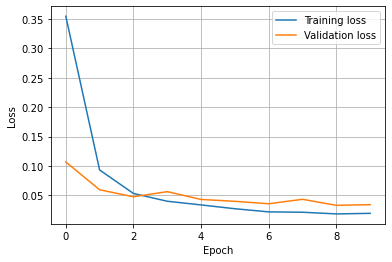

In [82]:
# Plot the loss
plt.plot(history.history['loss'], label = 'Training loss')
plt.plot(history.history['val_loss'], label = 'Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.show()

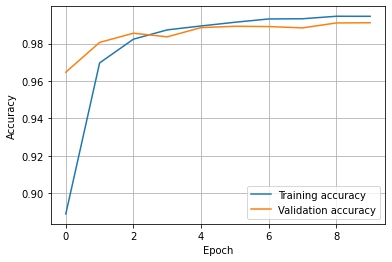

In [83]:
# Plot the accurcy
plt.plot(history.history['accuracy'], label = 'Training accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.show()

In [84]:
score_original_data = model.evaluate(original_test_data, onehot_labels, verbose = 0)
print('Test loss on original data:', score_original_data [0]) 
print('Test accuracy on original data:', score_original_data [1])

2022-05-31 10:21:19.023630: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Test loss on original data: 0.5836492776870728
Test accuracy on original data: 0.9994582533836365


In [85]:
print("Generate a prediction")
prediction = model.predict(X_train_aug)
print("prediction:", prediction)

classes = np.argmax(prediction, axis = 1)
# for i in range(len(classes)):
#     print(classes[i])
    
count_arr = np.bincount(classes)
for i in range(len(count_arr)):
    print(str(i) + " number "  + str(count_arr[i])) 

Generate a prediction


2022-05-31 10:21:20.653273: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


prediction: [[2.1899599e-19 1.7536139e-26 9.5016344e-17 ... 2.3664694e-21
  1.4353017e-19 1.0000000e+00]
 [1.9764421e-19 2.2240727e-30 3.7998377e-31 ... 1.6990401e-15
  3.7232632e-19 6.6537465e-26]
 [8.0853671e-18 2.4466621e-22 7.8932991e-21 ... 1.3472165e-10
  5.2011173e-19 1.0000000e+00]
 ...
 [1.5642156e-33 4.6973822e-25 0.0000000e+00 ... 1.5657077e-36
  0.0000000e+00 0.0000000e+00]
 [2.0313756e-27 3.7556203e-20 2.0712793e-33 ... 1.9914538e-28
  1.8294270e-37 7.5090813e-34]
 [1.0000000e+00 4.7313141e-29 9.3519865e-25 ... 1.3687671e-27
  7.1329326e-25 2.8886087e-32]]
0 number 2895
1 number 2895
2 number 3052
3 number 2915
4 number 2941
5 number 2902
6 number 2859
7 number 2825
8 number 2920
9 number 2908
10 number 2882
11 number 2960
12 number 2883
13 number 2916
14 number 2970
15 number 2866
16 number 2993
17 number 2769
18 number 2883
19 number 2857
20 number 2913
21 number 2941
22 number 2944
23 number 2885
24 number 2965
25 number 2877
26 number 2959


## Character segmentation

In [95]:
def boundingboxes_letters(image, image_dilated):
    boxcoordinates = []
    words_image = []
    letters = []

    copy = image.copy()
    thresholded = thresholding(image_dilated)

    cnts = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    
    for c in cnts:
        topleftx, toplefty, width, height = cv2.boundingRect(c)
        next_letter = [topleftx, toplefty, width, height]
        letters.append(next_letter)

    letters = sorted(letters, reverse=False)


    for letter in letters:
        topleftx, toplefty, width, height = letter

        #Reject contours that are too big or small to be likely letters, from average data taken
        if height<27 or width<17:
            continue

        if height>160 or width>80:
            continue

        cv2.rectangle(copy, (topleftx, toplefty), (topleftx + width, toplefty + height), (0,0,255), 2)  
        boxcoordinates.append((topleftx, toplefty, width, height))

        character = image[toplefty:toplefty+height, topleftx:topleftx+width]
        print("shape: "+str(character.shape))
        plt.figure(figsize=(3,3))
        plt.imshow(character, cmap="gray")
        plt.show()
        words_image.append(character)
    
    return words_image, copy, boxcoordinates

shape: (34, 57)


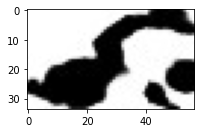

shape: (32, 23)


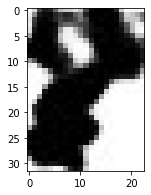

shape: (47, 20)


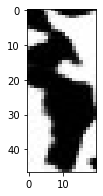

shape: (59, 46)


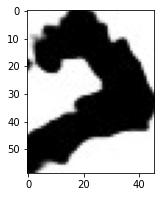

shape: (37, 37)


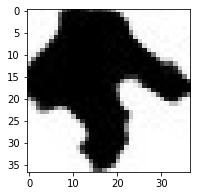

shape: (35, 23)


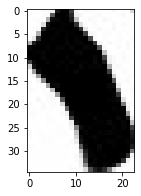

shape: (48, 37)


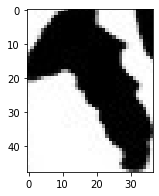

shape: (57, 67)


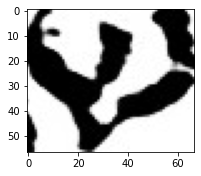

shape: (28, 17)


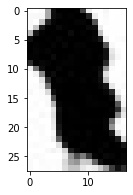

shape: (56, 46)


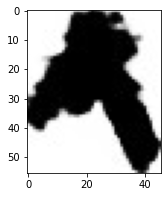

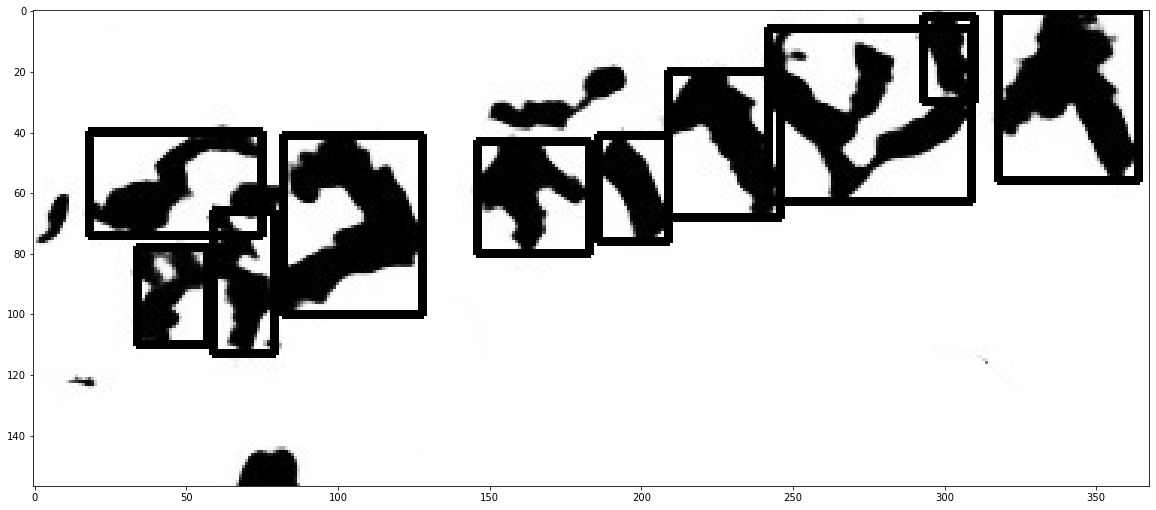

In [121]:
#Test one word with boundingboxes approach
test_word = words_per_line[0][1]
test_bound_word = test_word.copy()

kernel = np.ones((2,2), np.uint8)
test_bound_word_dilate = cv2.dilate(test_bound_word, kernel, iterations=1)


char, test_image, coordinates = boundingboxes_letters(test_bound_word, test_bound_word_dilate)

plt.figure(figsize=(20,20))
plt.imshow(test_image, cmap="gray")
plt.show()

## all crap/text stuff below here 

In [87]:
def sliding_window(image, peaks):
    windows = []
    stepsize = 5
    height = image.shape[0]
    width = 60
    toplefty = 0
    topleftx = peaks[0]
    
    for peak in peaks:
        begin = peak - stepsize
        print(begin)
        print("image shape:" +str(image.shape[1]-width))
        end = (peak + (2*stepsize))
        if (peak + 30) > image.shape[1]:
            topleftx = image.shape[1]-width
            window = image[toplefty:toplefty + height, topleftx:topleftx + width]
            window = cv2.resize(window, (38, 48))
            plt.figure(figsize=(3,3))
            plt.imshow(window, cmap="gray")
            plt.show()
            windows.append(window)
        else:
            for topleftx in range(begin, end, stepsize):
                print(topleftx)
                topleftx = max((topleftx - 30), 0)
                window = image[toplefty:toplefty + height, topleftx:topleftx + width]
                window = cv2.resize(window, (38, 48))
                plt.figure(figsize=(3,3))
                plt.imshow(window, cmap="gray")
                plt.show()
                windows.append(window)
    return windows
        

In [ ]:
kernel = np.ones((15,15), np.uint8)
test_chars = cv2.erode(test_word, kernel, iterations=1)

plt.figure(figsize=(3,3))
plt.imshow(test_chars, cmap="gray")
plt.show()


vpp = vertical_projections(test_chars)
plt.plot(vpp)
plt.title("Peaks")
plt.show()

minimum_peak = int((np.max(vpp)-np.min(vpp))/3)
peaks, _ = find_peaks(vpp, height=minimum_peak , distance=30)
plt.plot(vpp)
plt.title("Marked peaks")
plt.plot(peaks, vpp[peaks], "x")
plt.plot(np.zeros_like(vpp), "--", color="gray")
plt.show()

In [ ]:
peaks

In [ ]:
first = 1
new_peaks = []
for peak in peaks:
    #peaks lower than x value of 30 are not really dividers 
    if peak < 30:
        continue
    if first == 1:
        new_peak = int((15 + peak) / 2)
        new_peaks.append(new_peak)
        previous = peak
        first = 0
    else:            
        new_peak = int((previous + peak) / 2)
        new_peaks.append(new_peak)
        previous = peak
        
#add last peak
new_peak = int((peaks[len(peaks)-1] + (test_word.shape[1] - 5)) / 2)
new_peaks.append(new_peak)
peaks = new_peaks

In [ ]:
peaks

In [ ]:
#Predict the word per window. 
if test_word.shape[1] > 80:
    slide_peak_window = sliding_window(test_word, peaks)
    samples_to_predict = np.array(slide_peak_window)    
    predictions = model.predict(samples_to_predict)
    print(predictions)
    classes = np.argmax(predictions, axis = 1)
    print(classes)
    

In [ ]:
test_bound_word = test_word.copy()

kernel = np.ones((6,6), np.uint8)
test_bound_word_dilate = cv2.dilate(test_bound_word, kernel, iterations=1)


char, test_image, coordinates = boundingboxes_letters(test_bound_word, test_bound_word_dilate, 25, 100)

plt.figure(figsize=(5,5))
plt.imshow(test_image, cmap="gray")
plt.show()

In [ ]:
print(coordinates)

In [ ]:
# coordinates order = (topleftx, toplefty, width, height)

new_x_coordinates = []
for i in range(len(peaks)):
    if i > len(coordinates) - 1:
        new_x_coordinates.append(peaks[i])
    else:
        x_value = int(((coordinates[i][0] + 30) + (peaks[i])) / 2)
        new_x_coordinates.append(x_value)

In [ ]:
print(new_x_coordinates)

In [ ]:
if test_word.shape[1] > 80:
    slide_peak_window = sliding_window(test_word, new_x_coordinates)
    samples_to_predict = np.array(slide_peak_window)    
    predictions = model.predict(samples_to_predict)
    print(predictions)
    classes = np.argmax(predictions, axis = 1)
    print(classes)

What can we adjust tomorrow?

We can think about adjustable boxes for the boundings, because 60 is sometimes to big or to small
We can try the bounding box method on more examples
Create the most probable letter function


maybe make a huge sliding window and then use bounding boxes, if it is in several boxes we can create maybe a window? 

In [ ]:
def sliding_window_big(image):
    windows = []
    stepsize = 10
    height = image.shape[0]
    width = 100
    toplefty = 0
    for topleftx in range(0, (image.shape[1] -100), stepsize):
        print(topleftx)
        window = image[toplefty:toplefty + height, topleftx:topleftx + width]
#         window = cv2.resize(window, (38, 48))
        plt.figure(figsize=(3,3))
        plt.imshow(window, cmap="gray")
        plt.show()
        windows.append(window)
    return windows   

In [ ]:
coordinates_characters = [x]
for word in slide_peak_window_big:
    test_bound_word = word.copy()
    kernel = np.ones((1,1), np.uint8)
    test_bound_word_dilate = cv2.erode(test_bound_word, kernel, iterations=1)
    char, test_image, coordinates = boundingboxes_letters(test_bound_word, test_bound_word_dilate)
    print(coordinates)
    plt.figure(figsize=(5,5))
    plt.imshow(test_image, cmap="gray")
    plt.show()

In [ ]:
test_word_dilate = test_word
char, test_image = boundingboxes(invert_test_word, test_bound_word_dilate, 20, 200)

In [ ]:
binary_test_word = get_binary(test_word)

In [ ]:
binary_test_word = get_binary(test_word)
numBlackPixels = np.sum(binary_test_word == 1)
print(numBlackPixels)

In [ ]:
numWhitePixels = np.sum(binary_test_word == 0)
print(numWhitePixels)

In [ ]:
numBlackPixels/numWhitePixels